In [1]:
import emcee
import matplotlib
import numpy as np
import corner
import scipy.optimize as op

%matplotlib inline  

# some important variables
g = 6.6743e-8
msun = 1.989e33
au = 1.496e13
pi = 3.14159

In [2]:
nbin = 58 ## number of binaries in sample
nvar = 5

## read in delK, parallax
delk = np.zeros(nbin)
edelk = np.zeros(nbin)
plxval = np.zeros(nbin)
plxprior = np.zeros(nbin)
name = strs = ['']*nbin
k = np.zeros(nbin)
ek = np.zeros(nbin)
f = open('data2.txt','r')
header1 = f.readline()
i=0
for line in f:
    line = line.strip()
    columns = line.split()
    name[i] = columns[0]
    delk[i] = float(columns[1])
    edelk[i] = float(columns[2])
    plxval[i] = float(columns[3])
    plxprior[i] = float(columns[4])
    k[i] = float(columns[5])
    ek[i] = float(columns[6])
    i+=1
f.close()

## now for the sma**3/per**2
f = open('fits.txt','r')
header1 = f.readline()
i=0
smaper = np.zeros(nbin)
esmaper = np.zeros(nbin)
for line in f:
    line = line.strip()
    columns = line.split()
    smaper[i] = float(columns[0])
    esmaper[i] = float(columns[1])
    i+=1
f.close()

fluxratio = 10.0**(delk/2.5)
del_eps = 2.5*np.log10(1.0+1.0/fluxratio)
kp = del_eps+k
ks = kp + delk

# compute MC errors on Kp, Ks
mcsize = 50000
ekp = kp*0.
eks = ks*0.
for i in range(0,len(ks)):
    ktmp = k[i]+ek[i]*np.random.standard_normal(mcsize)
    deltmp = delk[i]+edelk[i]*np.random.standard_normal(mcsize)
    fluxratio = 10.0**(deltmp/2.5)
    del_eps = 2.5*np.log10(1.0+1.0/fluxratio)
    kpt = del_eps+ktmp
    kst = kp[i] + ktmp
    ekp[i] = np.std(kpt)
    eks[i] = np.std(kst)


result_ben = np.array([0.2311,-0.1352, 0.0400, 0.0038, -0.0032]) # benedict fit value
result1 = np.array([0.23323026,-0.10887911, 0.019990399, 0.00027286744, -0.00046073982])# Mann fit value
result2 = plxval
result_delf = [0.001*1.8,0.001*6.12,0.001*13.205,-6.2315*0.001,0.001*0.37529]
result3= np.array([-0.663541,-0.212175 , 0.00594868 ,  0.00641549, -0.000416446]) ## one I measured in IDL
result3= np.array([-0.64329003970411125,-0.20043764801036046,-0.0041776516821012992,0.0033655838569557478,0.00030012649616073089])
result3 = np.array([ -6.43290040e-01, -2.00437648e-01 ,-4.17765168e-03,  3.36558386e-03,3.00126496e-04])
#result3 = [-0.68289052,-0.21267384,0.010006863,0.0060963733,-0.000416446] ## this one satisfies the requirements of monotonic relation
#scat = np.array([0.1]) # fractional intrinsic scatter in the relation
result = np.concatenate([result3,result2])


In [3]:
factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
empmass = factor*smaper/plxval**3
e_empmass = empmass*np.sqrt((esmaper/smaper)**2 +9.0*(plxprior/plxval)**2)

In [4]:
## this is mostly for checking things are reasonable
mka = kp - 5.0*(np.log10(1000.0/plxval)-1.)
mkb = ks - 5.0*(np.log10(1000.0/plxval)-1.)
a, b, c, d, e = result3
mka_err = 0.02## for now
mkb_err = 0.02## for now
mass1 = 10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4)
mass2 = 10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4)
mass1_err = (np.log(10)*(b+2*c*(mka-7.5)+3*d*(mka-7.5)**2+4*e*(mka-7.5)**3))*mass1*mka_err
mass2_err = (np.log(10)*(b+2*c*(mkb-7.5)+3*d*(mkb-7.5)**2+4*e*(mkb-7.5)**3))*mass2*mkb_err
#mass1 = 10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3)
#mass2 = 10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3)
#mass1_err = (np.log(10)*(b+2*c*(mka-7.5)+3*d*(mka-7.5)**2))*mass1*mka_err
#mass2_err = (np.log(10)*(b+2*c*(mkb-7.5)+3*d*(mkb-7.5)**2))*mass2*mkb_err


model_err = np.sqrt(mass1_err**2+mass2_err**2)
model_err2 = np.sqrt(mass1_err**2+mass2_err**2)#+(scat*mass1)**2+(scat*mass2)**2 )
model = mass1+mass2

for i in range(0,len(empmass)):
    print "{:10s}".format(name[i]), \
    "{0:.3f}".format(empmass[i]),"{0:.3f}".format(e_empmass[i]), \
    "{0:.4f}".format(model[i]),"{0:.4f}".format(model_err[i]),"{0:.3f}".format(100*model_err[i]/model[i]), \
    "{0:.4f}".format(mka[i]),"{0:.4f}".format(mkb[i]), \
    "{0:.3f}".format(ekp[i]),"{0:.3f}".format(eks[i]), \
    "{0:.3f}".format(mass1[i]),"{0:.3f}".format(mass2[i]), \
    "{0:.1f}".format(np.abs(empmass[i]-model[i])/np.sqrt(e_empmass[i]**2+model_err[i]**2))   
    
print np.sum((empmass-model)**2/(e_empmass**2+model_err**2))/(empmass.size-5.)
print np.sum((empmass-model)**2/(e_empmass**2+model_err2**2 ))/(empmass.size-5.)

GJ623      0.494 0.004 0.4666 0.0031 0.673 6.4968 9.0678 0.023 0.023 0.355 0.111 5.0
GJ4024     0.917 0.139 0.8819 0.0048 0.540 5.5041 6.4691 0.019 0.018 0.523 0.359 0.3
PMJ02133+3648 0.245 0.035 0.2596 0.0017 0.659 8.1313 9.6003 0.018 0.018 0.170 0.090 0.4
HIP11542   1.457 0.183 1.3387 0.0055 0.408 4.6013 4.8643 0.019 0.018 0.695 0.644 0.6
HD239960   0.460 0.011 0.4382 0.0029 0.660 7.1190 8.1570 0.029 0.029 0.271 0.168 2.0
HD15285    1.389 0.079 1.3535 0.0055 0.404 4.6580 4.7310 0.020 0.018 0.684 0.670 0.4
Gl844      0.871 0.095 0.9074 0.0049 0.540 5.8306 5.9476 0.022 0.021 0.464 0.444 0.4
HIP9724    0.514 0.027 0.5535 0.0036 0.642 5.9100 9.2460 0.020 0.020 0.450 0.103 1.5
Gl831      0.418 0.003 0.4146 0.0028 0.666 7.1793 8.3793 0.020 0.020 0.263 0.151 0.9
Gl804      0.996 0.135 0.9399 0.0049 0.519 5.2621 6.3851 0.016 0.016 0.568 0.372 0.4
Gl747      0.429 0.026 0.4329 0.0028 0.655 7.5507 7.6637 0.021 0.020 0.222 0.211 0.1
Gl695C     0.868 0.023 0.8306 0.0047 0.562 5.9652 6.2712 0.018

In [5]:
print np.max(mkb),np.min(mka)

11.0598237701 4.32178406821


In [6]:
def lnlike(theta, smaper, esmaper, kp, ks, ekp, eks):
    zp = 7.5e0
    au = 1.496e13
    msun = 1.989e33
    g = 6.6743e-8 
    a, b, c, d, e = theta[0:5]
    mplx = theta[5:theta.size]
    if np.min(mplx) <= 0:
        return -np.inf
    factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
    empmass = factor*smaper/mplx**3
    e_empmass = empmass*(esmaper/smaper)**2
    mka = kp - 5.0*(np.log10(1000.0/mplx)-1.)
    mkb = ks - 5.0*(np.log10(1000.0/mplx)-1.)
    mka -= zp
    mkb -= zp
    mass1 = 10.0**(a + b*mka + c*mka**2. + d*mka**3. + e*mka**4.)
    mass2 = 10.0**(a + b*mkb + c*mkb**2. + d*mkb**3. + e*mkb**4.)
    #mass1 = 10.0**(a + b*mka + c*mka**2. + d*mka**3.)
    #mass2 = 10.0**(a + b*mkb + c*mkb**2. + d*mkb**3.)
    if np.min(mass1) <= 0 or np.min(mass2) <= 0:
        return -np.inf
    
    ## this is where we check to see if the relation always does brighter=higher mass (if not return -np.inf)
    #rng = [np.min(np.concatenate([mka,mkb])),np.max(np.concatenate([mka,mkb]))]
    mk = np.linspace(4.2,11.1,100)
    l = 10.0**(a + b*(mk-zp) + c*(mk-zp)**2. + d*(mk-zp)**3. + e*(mk-zp)**4)
    check = all(l[i] >= l[i+1] for i in xrange(len(l)-1))
    if not check:
        return -np.inf
    ## there's a better way to do this... probably to check to see if the slope goes negative

    mass1_err = np.abs((np.log(10.)*(b+2.*c*mka+3.*d*mka**2+4.*e*mka**3.))*mass1*ekp)
    mass2_err = np.abs((np.log(10.)*(b+2.*c*mkb+3.*d*mkb**2+4.*e*mkb**3.))*mass2*eks)
    #mass1_err = np.abs((np.log(10.)*(b+2.*c*mka+3.*d*mka**2))*mass1*mka_err)
    #mass2_err = np.abs((np.log(10.)*(b+2.*c*mkb+3.*d*mkb**2))*mass2*mkb_err)
        
    model_err = np.sqrt(mass1_err**2+mass2_err**2)#+scat**2)
    model = mass1+mass2
    inv_sigma2 = 1.0/np.sqrt(e_empmass**2+model_err**2)
    return -0.5*(np.sum((empmass-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [7]:
def lnprior(theta, plxval, plxprior):
    mplx = theta[5:theta.size]
    lp = 0
    if np.min(mplx) <= 0:
        return -np.inf
    lp += np.sum(((mplx-plxval)**2)/(plxprior)**2)
    lp*=(-0.5)
    if not np.isfinite(lp):
        return 0.0
    return lp

In [8]:
def lnprob(theta, plxval, plxprior, smaper, esmaper, kp, ks, ekp, eks):
    lp = lnprior(theta, plxval, plxprior)
    if not np.isfinite(lp):
        return -np.inf
    like = lnlike(theta, smaper, esmaper, kp, ks, ekp, eks)
    if not np.isfinite(like):
        return -np.inf
    val = lp + like
    return val

In [9]:
import time
start_time = time.time()
ndim, nwalkers = result.size, 800
pos = [result + 1e-2*result*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(plxval, plxprior, smaper, esmaper, kp, ks, ekp, eks),
                               threads=6)
## burn-in and/or testing
smallstep = 5000
bigstep =  600000
pos, prob, state = sampler.run_mcmc(pos, smallstep)
print 'Finished burn/test phase runtime (minutes):'
print (time.time() - start_time)/60
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print 'Expected time (hours):'
print ((time.time() - start_time)/60)*(bigstep/smallstep)/60


Finished burn/test phase runtime (minutes):
85.1117228349
Mean acceptance fraction: 0.157
Expected time (hours):
42.5562711159


In [10]:
dat = sampler.chain
prob = sampler.lnprobability
accept = sampler.acceptance_fraction
dat = sampler.flatchain#chain
like = sampler.flatlnprobability
arr = dat
best = (like == max(like))
a = arr[best,0:5]#np.median(arr[:,0])
print a
print result3

[[ -6.42474198e-01  -1.99418906e-01  -2.91507802e-03   4.39607750e-03
    2.64287507e-04]
 [ -6.42474198e-01  -1.99418906e-01  -2.91507802e-03   4.39607750e-03
    2.64287507e-04]]
[ -6.43290040e-01  -2.00437648e-01  -4.17765168e-03   3.36558386e-03
   3.00126496e-04]


In [11]:
sampler.reset()
start_time = time.time()
nsteps = bigstep
thin = 100
kwargs = {'thin': thin }
print 'Starting run!'
for i, result in enumerate(sampler.sample(pos, iterations=nsteps, **kwargs)):
    if (i+1) % 10000 == 0:
        print("{0:5.1%}".format(float(i) / nsteps)),
        ("{0:5.2%}".format((time.time() - start_time)/60))
print ' '
print 'Done, runtime (hours):'
print (time.time() - start_time)/3600
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Starting run!
 8.3% 16.7% 25.0% 33.3% 41.7% 50.0% 58.3% 66.7% 75.0% 83.3% 91.7% 100.0%  
Done, runtime (hours):
29.288307147
Mean acceptance fraction: 0.154


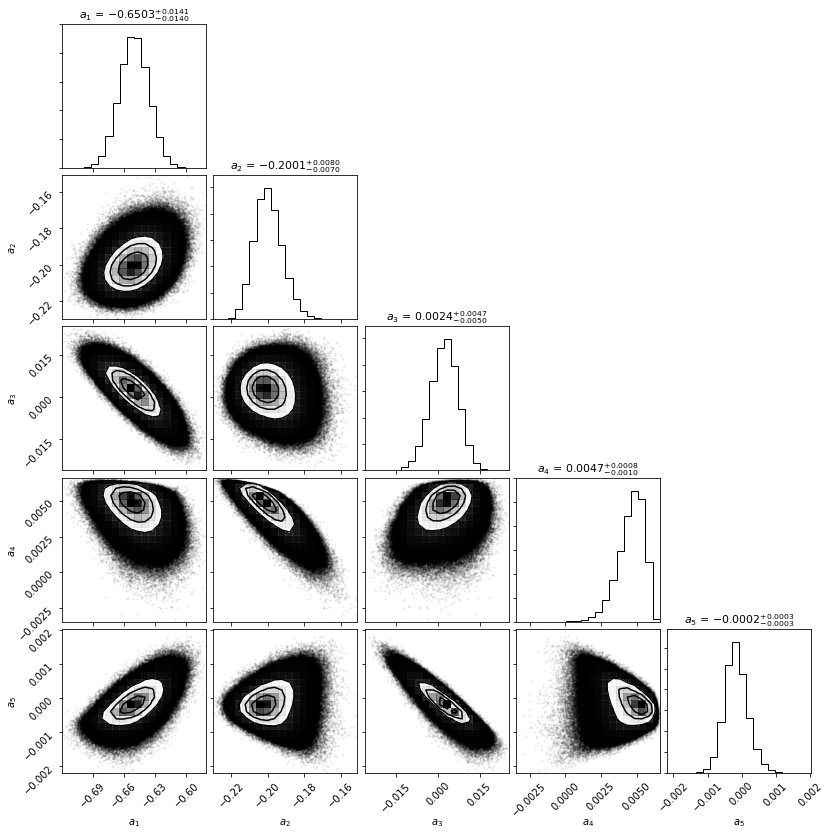

In [12]:
#print dat.shape,nwalkers,nsteps,thin
import corner
from matplotlib.backends.backend_pdf import PdfPages
dat = sampler.flatchain#chain
like = sampler.flatlnprobability
arr = dat

fig = corner.corner(arr[:,0:nvar], labels=[r'$a_1$',r'$a_2$',r'$a_3$',r'$a_4$',r'$a_5$'], show_titles=True, title_kwargs={"fontsize": 11},title_fmt='.4f')
pp = PdfPages('output_params_log.pdf')
pp.savefig(fig)
pp.close()

In [13]:
dat = sampler.chain
prob = sampler.lnprobability
accept = sampler.acceptance_fraction
arr = dat.reshape((dat.shape)[0]*(dat.shape)[1],dat.shape[2])
print 'name plx_mcmc plx_err_mcmc plxinput plx_prior diff_sig1 diff_sig2'
for i in range(nvar,dat.shape[2]):
    print "{:10s}".format(name[i-nvar]), \
    i,\
    "{0:.4f}".format(np.median(arr[:,i])),"{0:.4f}".format(np.std(arr[:,i])),"{0:.4f}".format(plxprior[i-nvar]), \
    "{0:.4f}".format(plxval[i-nvar]),"{0:.4f}".format((plxval[i-nvar]-np.median(arr[:,i]))/plxprior[i-nvar]), \
    "{0:.4f}".format((plxval[i-nvar]-np.median(arr[:,i]))/np.sqrt(plxprior[i-nvar]**2+np.std(arr[:,i])**2))
    

name plx_mcmc plx_err_mcmc plxinput plx_prior diff_sig1 diff_sig2
GJ623      5 125.0054 0.2997 0.3000 125.0000 -0.0181 -0.0128
GJ4024     6 50.8740 1.4614 2.5000 50.1000 -0.3096 -0.2673
PMJ02133+3648 7 74.0166 2.9664 3.5000 74.6000 0.1667 0.1272
HIP11542   8 39.7298 0.7449 1.6000 38.2000 -0.9561 -0.8668
HD239960   9 249.9928 1.8910 1.9000 249.9000 -0.0488 -0.0346
HD15285    10 59.0632 0.8122 1.1000 58.3000 -0.6938 -0.5582
Gl844      11 61.3520 1.6497 2.2000 61.8000 0.2036 0.1629
HIP9724    12 109.2238 1.7968 1.8700 109.5900 0.1958 0.1412
Gl831      13 125.3023 0.3004 0.3000 125.3000 -0.0078 -0.0055
Gl804      14 48.4143 1.2077 2.1000 47.4000 -0.4830 -0.4187
Gl747      15 122.3850 2.3786 2.5000 122.3000 -0.0340 -0.0246
Gl695C     16 120.3339 0.1601 0.1600 120.3300 -0.0243 -0.0172
Gl660      17 86.2937 2.1373 2.4700 85.2300 -0.4306 -0.3256
Gl54       18 126.9107 0.3998 0.4000 126.9000 -0.0268 -0.0190
Gl494      19 85.5848 1.3385 1.5000 85.5000 -0.0565 -0.0422
Gl473      20 227.5457 4.454

In [18]:
factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
mass = factor*smaper/plxval**3
#e_empmass = empmass*np.sqrt((esmaper/smaper)**2 +9.0*(plxprior/plxval)**2)
#sma_au = sma*au*(1000/plxval)
#mass = (4.*(pi**2.))*((sma_au**3./per**2.)/g)/msun

mka = kp - 5.0*(np.log10(1000.0/plxval)-1.)
mkb = ks - 5.0*(np.log10(1000.0/plxval)-1.)

best = ((like == max(like)))
a = arr[best,0]#np.median(arr[:,0])
b = arr[best,1]#np.median(arr[:,1])
c = arr[best,2]#np.median(arr[:,2])
d = arr[best,3]#np.median(arr[:,3])
e = arr[best,4]#np.median(arr[:,4])
print a,b,c,d,e


mass1 = 10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4)
mass2 = 10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4)
#mass1 = 10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3)
#mass2 = 10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3)
sysmass = mass1+mass2
a, b, c, d, e = result1
mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
sysmass_mann = mass1+mass2
a, b, c, d, e = result_ben
mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
sysmass_ben = mass1+mass2

[-0.65601097] [-0.20126132] [ 0.00405569] [ 0.00504302] [-0.00025251]


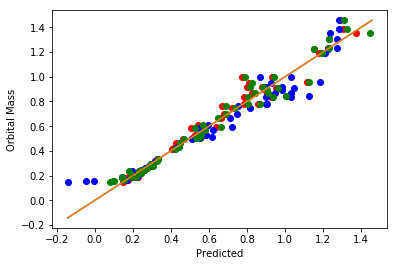

In [19]:
import matplotlib.pyplot as plt

rng = [np.min(np.concatenate([sysmass,sysmass_ben,mass])),
         np.max(np.concatenate([sysmass,sysmass_ben,mass]))]
plt.figure()
plt.plot(sysmass,mass,'ro')
plt.ylabel('Orbital Mass')
plt.xlabel('Predicted')
plt.plot(sysmass_ben,mass,'ro',color='b')
plt.plot(rng,rng)
plt.plot(sysmass_mann,mass,'ro',color='g')
plt.plot(rng,rng)
## blue = benedict
## green = mann idl
## red = python

74.0166096965 74.6
(4800000,) (4800000,)


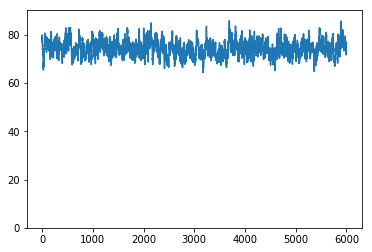

In [20]:
newprob = prob.reshape((prob.shape)[0]*(dat.shape)[1])
num = 7
plt.plot(dat[2,:,num])
print np.median(arr[:,num]),plxval[num-5]

#
print newprob.shape,arr[:,0].shape
n, bins, patches = plt.hist(newprob[np.isfinite(newprob)], 50, normed=1, facecolor='green', alpha=0.75)
plt.show()

[-0.65601097] [-0.20126132] [ 0.00405569] [ 0.00504302] [-0.00025251]
[ 26.11257197]


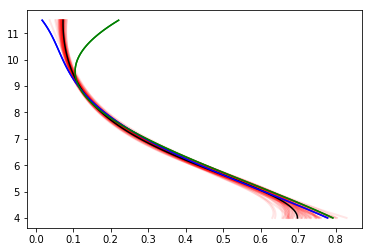

In [23]:
best = (like == max(like))
a = arr[best,0]#np.median(arr[:,0])
b = arr[best,1]#np.median(arr[:,1])
c = arr[best,2]#np.median(arr[:,2])
d = arr[best,3]#np.median(arr[:,3])
e = arr[best,4]#np.median(arr[:,3])
scat = arr[best,55]

print a,b,c,d,e
print scat
rng = [np.min(np.concatenate([mka,mkb])),np.max(np.concatenate([mka,mkb]))]
rng = [4,11.5]
mk = np.linspace(rng[0],rng[1],100)
mass1 = 10.0**(a + b*(mk-7.5) + c*(mk-7.5)**2 + d*(mk-7.5)**3 + e*(mk-7.5)**4)
a, b, c, d, e = result1
mass2 = a + b*(mk-7.5) + c*(mk-7.5)**2 + d*(mk-7.5)**3 + e*(mk-7.5)**4
mass3 = 0.585825902+3.87151019e-1*mk-1.21729937e-1*mk**2.+1.05529583e-2*mk**3.-2.72615872e-4*mk**4.

## red = new fit
## blue = Benedict
## green = How to constrain your M dwarf
#plt.plot(mk,mass1,color='o')
plt.plot(mass2,mk,color='b')
plt.plot(mass3,mk,color='g')


for i in range(0,60):
    index = np.random.randint(len(arr[:,0]))
    if np.isfinite(newprob[index]):
        a, b, c, d, e= arr[index,0:nvar]
        mass = 10.0**(a + b*(mk-7.5) + c*(mk-7.5)**2 + d*(mk-7.5)**3 + e*(mk-7.5)**4)
        plt.plot(mass,mk,color='r',lw=2,alpha=0.1)

plt.plot(mass1,mk,color='black')
plt.plot(mass2,mk,color='b')
plt.plot(mass3,mk,color='g')

plt.show()


In [27]:
print sampler.chain.shape
print sampler.lnprobability.shape
short = sampler.chain[:,:,0:nvar]
print short.shape
#print np.median(sampler.chain[:,:,5])

(800, 6000, 63)
(800, 6000)
(800, 6000, 5)


In [28]:
## save out the relevant chains
import pyfits
pyfits.writeto('Mk-Mass_log_emcee5_short.fits', short, clobber=True)
pyfits.writeto('Mk-Mass_log_emcee5.fits', sampler.chain, clobber=True)
pyfits.writeto('Mk-Mass_log_emcee5_accept.fits', sampler.acceptance_fraction, clobber=True)
pyfits.writeto('Mk-Mass_log_emcee5_lnprob.fits', sampler.lnprobability, clobber=True)
short = sampler
#pyfits.writeto('Mk-Mass_log_emcee_acor2.fits', sampler.acor, clobber=True)